Part 2: GTSAM with 6 images

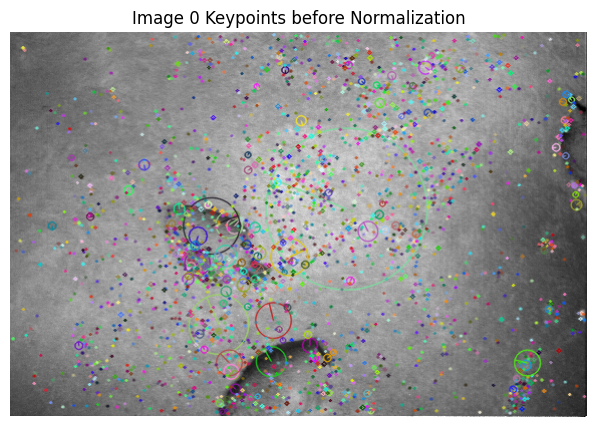

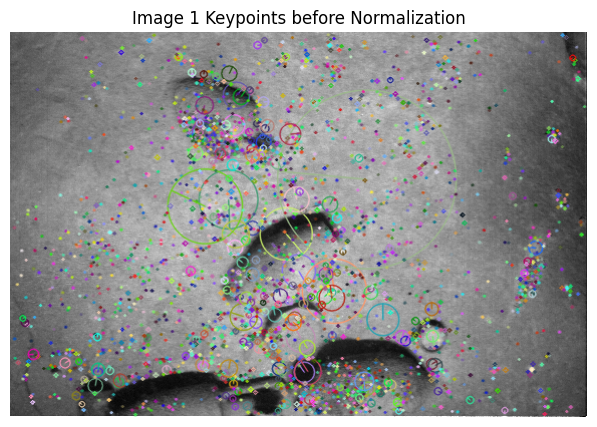

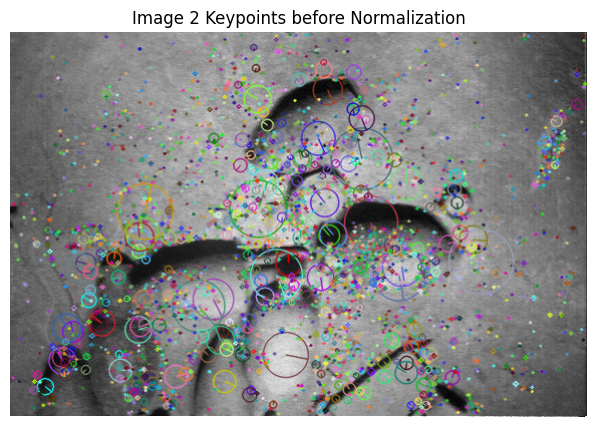

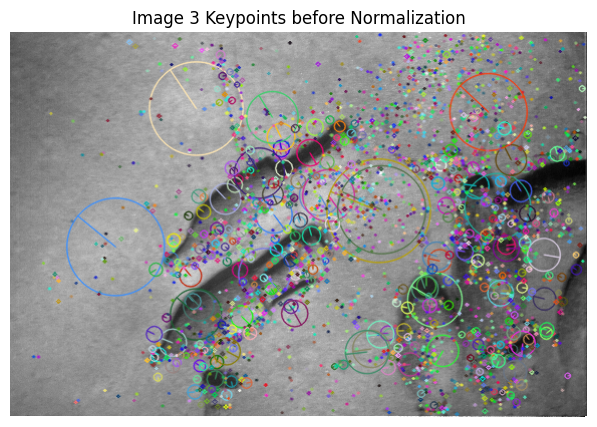

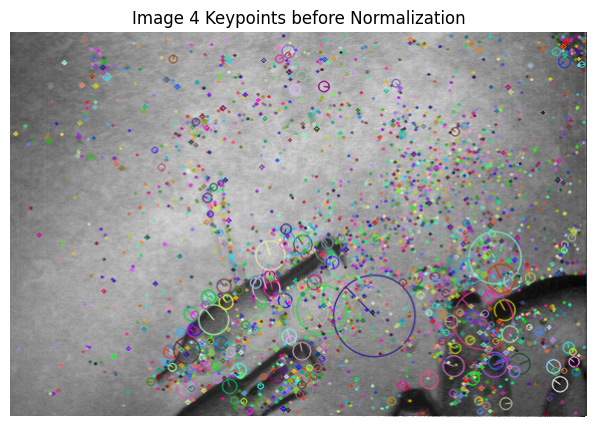

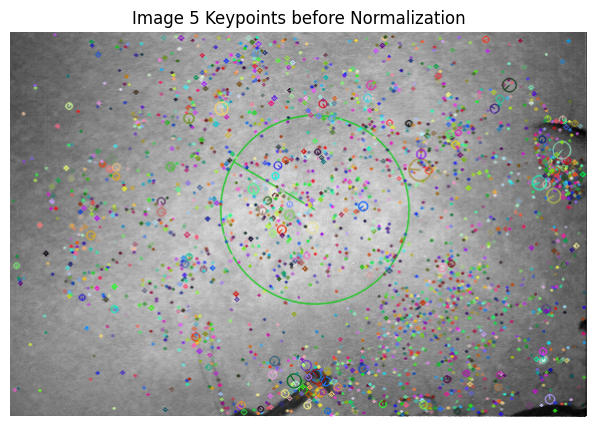

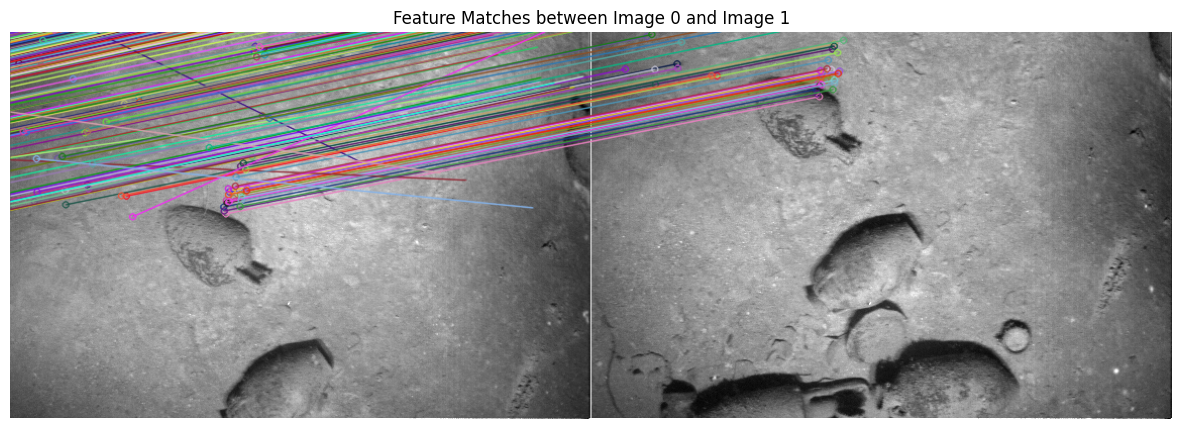

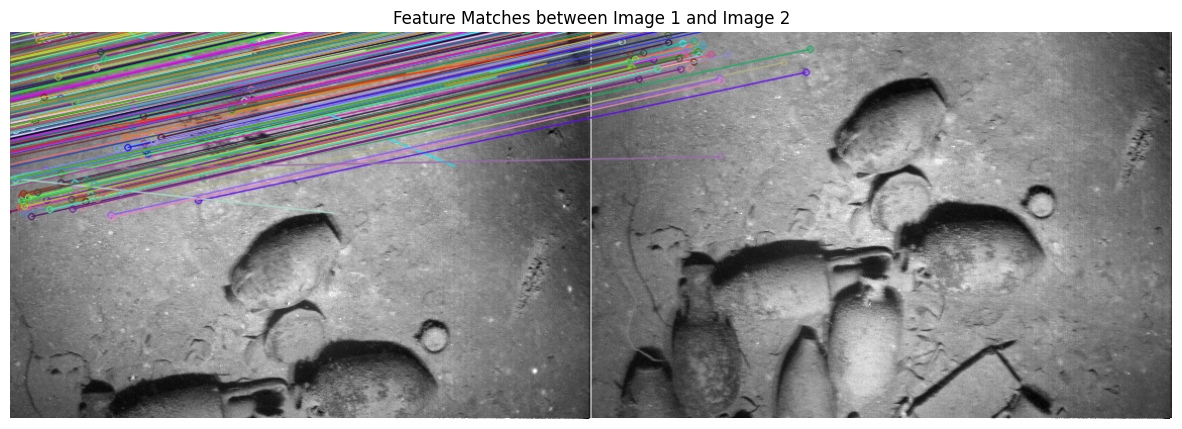

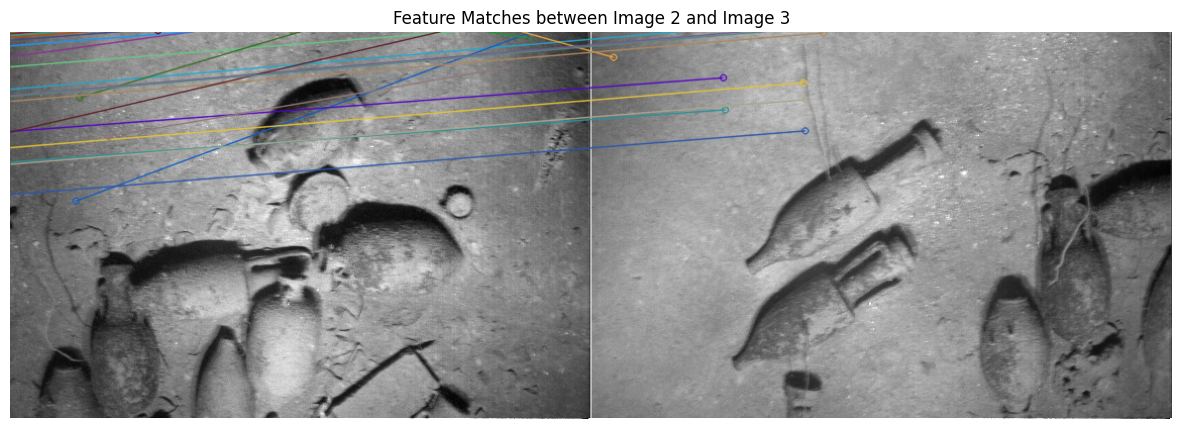

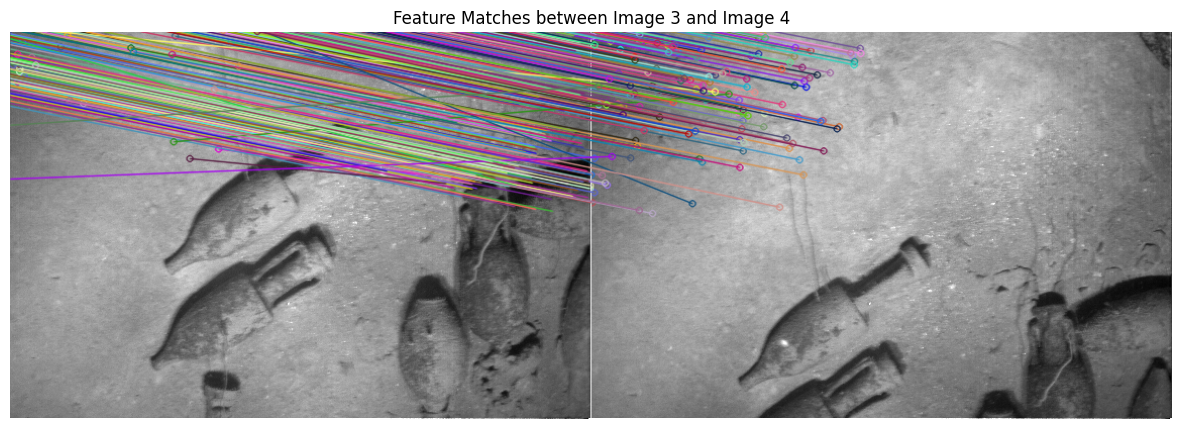

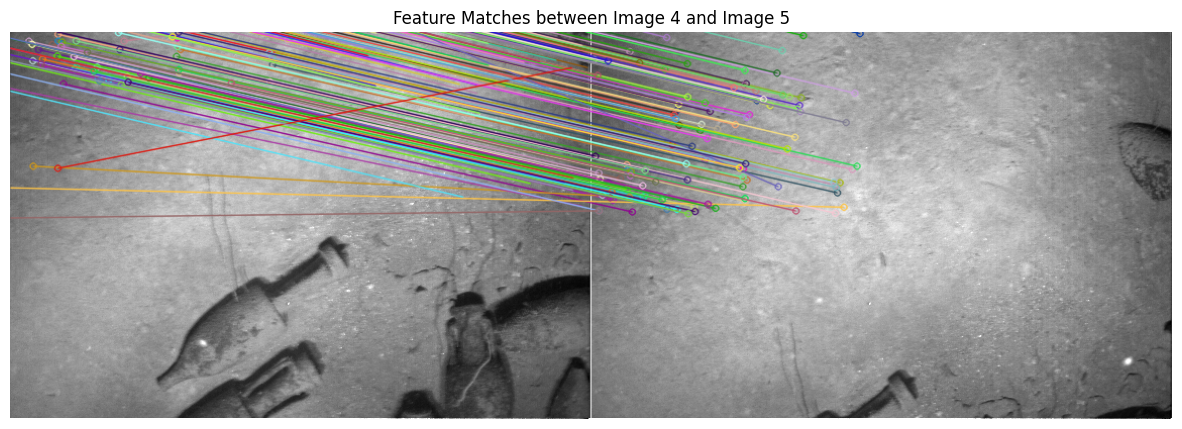

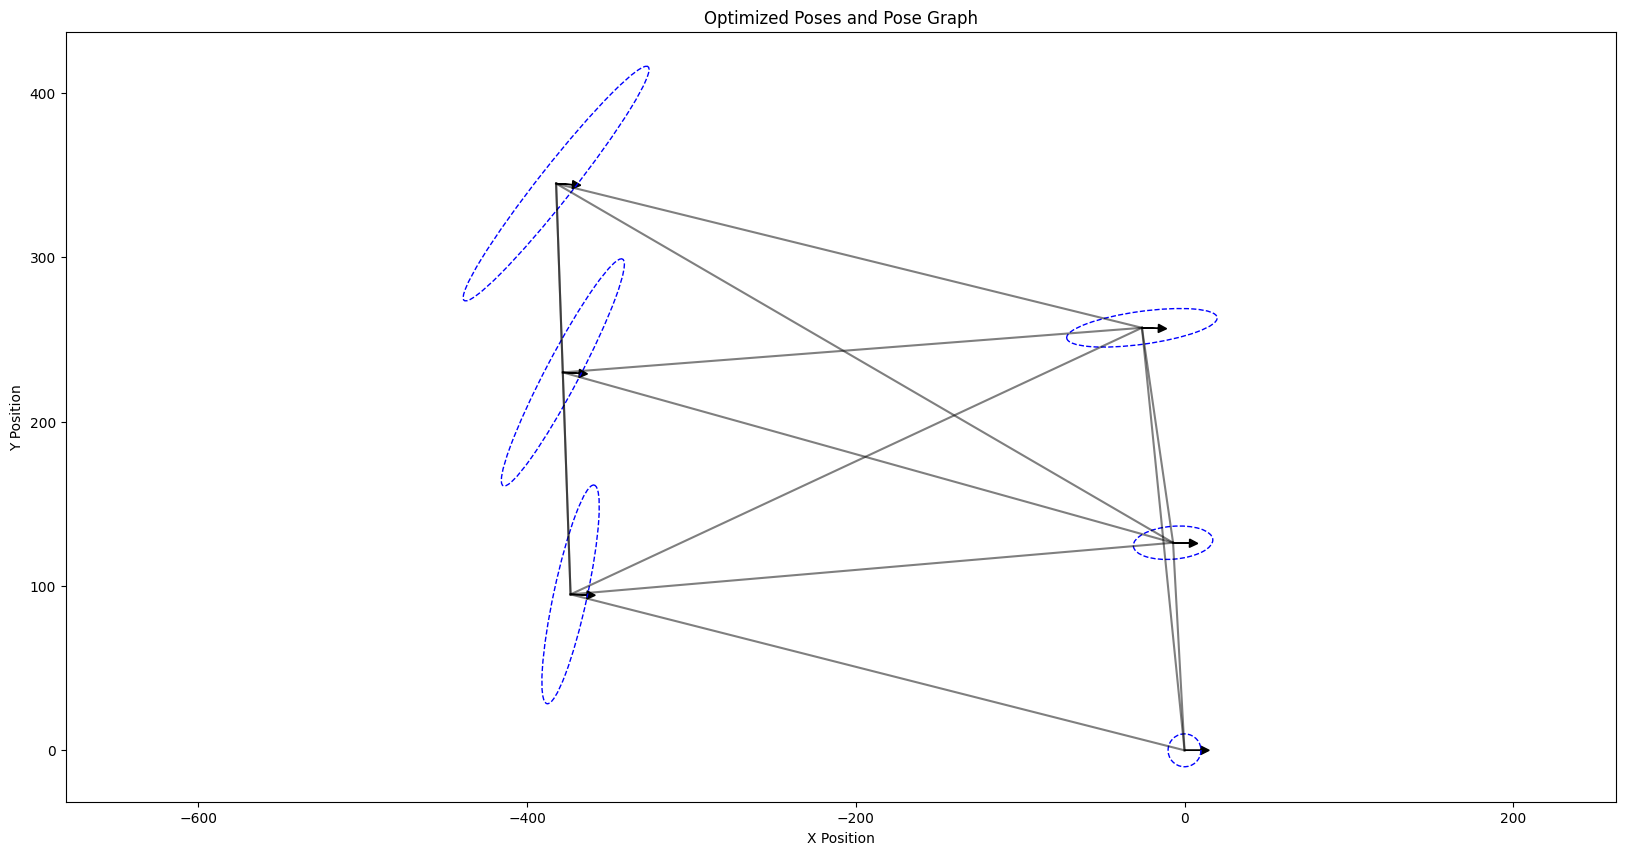

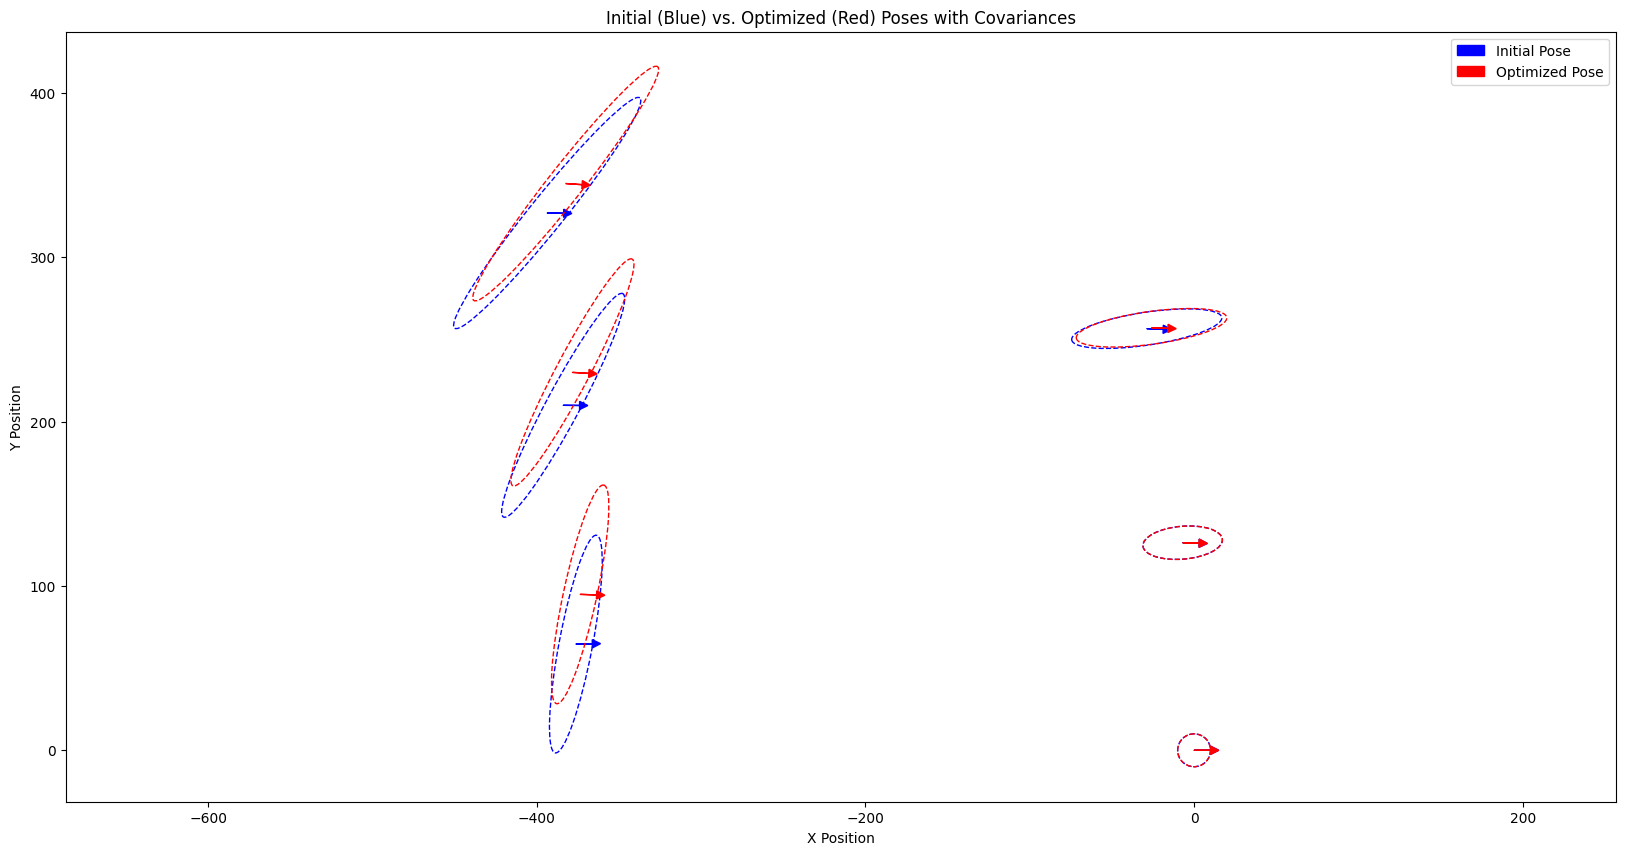

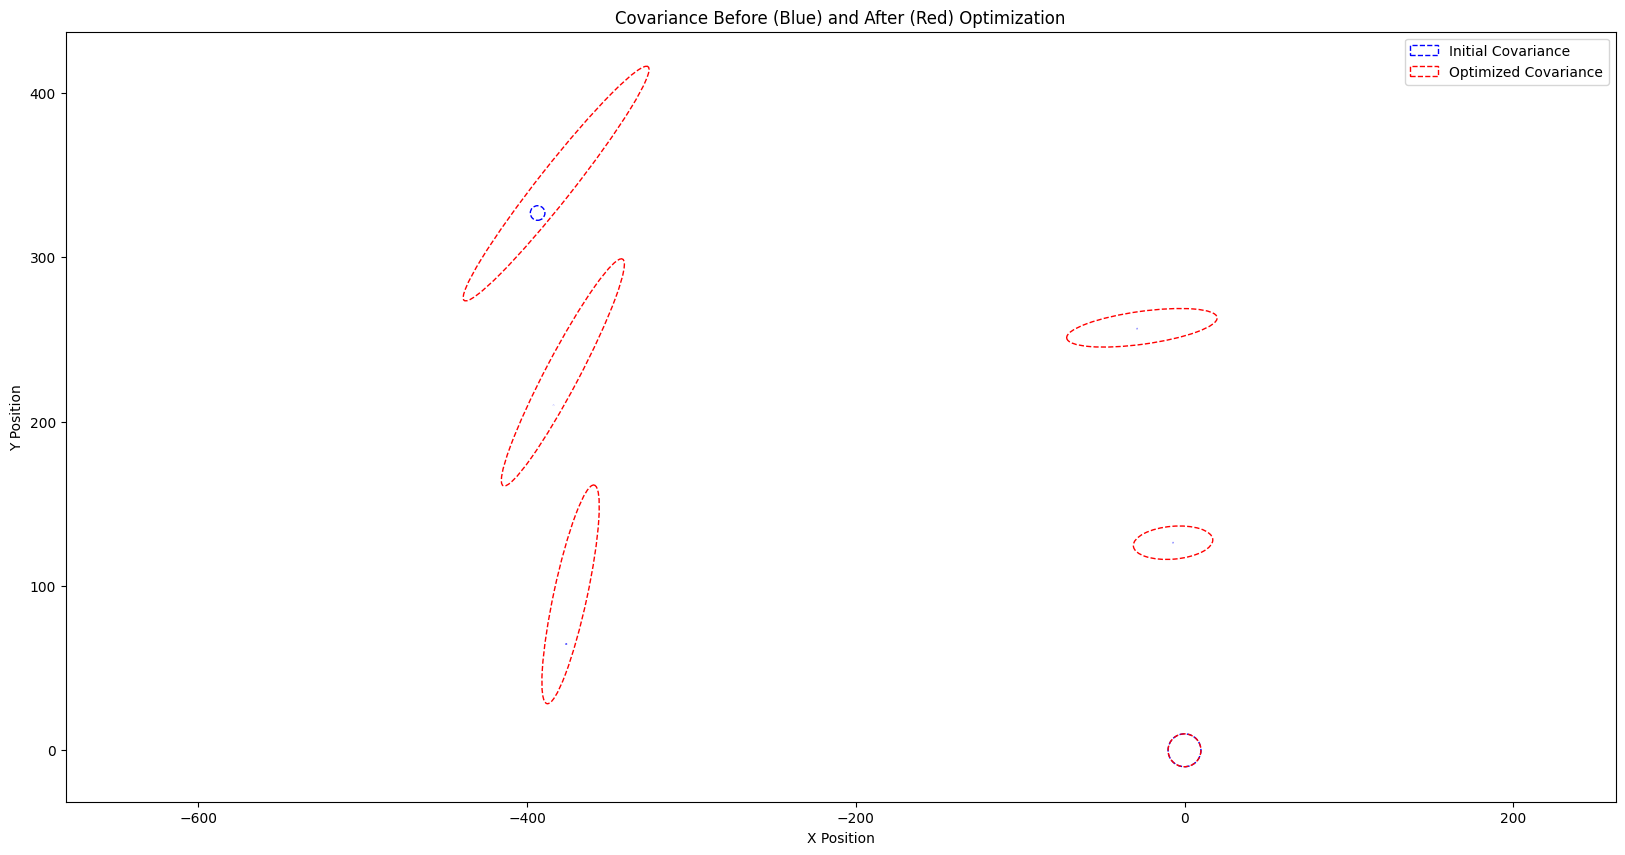

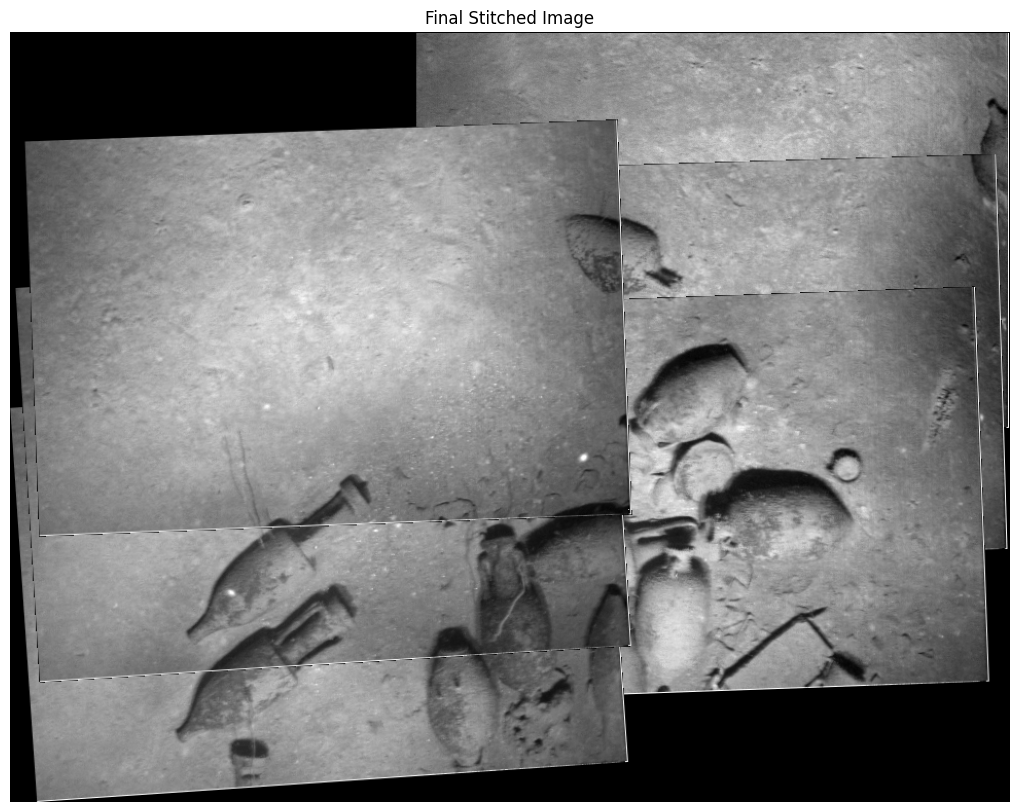

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import itertools
import gtsam
import gtsam.utils.plot
from matplotlib.patches import Ellipse

def main():
    # Set default figure size
    plt.rcParams["figure.figsize"] = (20, 10)
    
    # Directory containing the 6 images
    image_dir = '/home/kasturi/AFR_EECE7150/2D_ImgStitch/6Images'  # Update this path to your images directory
    
    # -----------------------------
    # 1. Load Images and Camera Matrix
    # -----------------------------
    
    images = []
    
    for filename in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            # Normalize image intensity to range [0, 255]
            cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
            images.append(image)
    
    if not images:
        raise ValueError("No images found in the specified directory.")
    
    image_height, image_width = images[0].shape[:2]
    
    # Define an approximate camera matrix (intrinsic parameters)
    camera_matrix = np.array([
        [1, 0, image_width / 2],
        [0, 1, image_height / 2],
        [0, 0, 1]
    ])
    
    # -----------------------------
    # 2. Non-Maximum Suppression
    # -----------------------------
    
    def compute_nms_mask(keypoints, image_shape, radius=2):
        """
        Compute Non-Maximum Suppression mask for keypoints.
        Retains keypoints with the highest response within a local neighborhood.
        """
        binary_image = np.zeros(image_shape, dtype=np.uint8)
        responses = np.array([kp.response for kp in keypoints])
        sorted_indices = np.flip(np.argsort(responses))
        nms_mask = []
        for idx in sorted_indices:
            x, y = int(round(keypoints[idx].pt[0])), int(round(keypoints[idx].pt[1]))
            if binary_image[y, x] == 0:
                nms_mask.append(idx)
                # Suppress neighbors within the specified radius
                cv2.circle(binary_image, (x, y), radius, 255, -1)
        return nms_mask
    
    # -----------------------------
    # 3. Keypoint Normalization
    # -----------------------------
    
    def normalize_keypoints(keypoints, camera_matrix):
        """
        Normalize keypoints using the inverse camera matrix.
        """
        inv_K = np.linalg.inv(camera_matrix)
        for kp in keypoints:
            pt_homogeneous = np.array([kp.pt[0], kp.pt[1], 1.0])
            normalized_pt = inv_K @ pt_homogeneous
            kp.pt = tuple(normalized_pt[:-1])
    
    # -----------------------------
    # 4. Compute SIFT Features and Visualize Keypoints
    # -----------------------------
    
    sift = cv2.SIFT_create(
        nfeatures=4000,
        nOctaveLayers=12,
        contrastThreshold=0.025,
        sigma=1.5
    )
    keypoints_list = []
    descriptors_list = []
    
    for idx, image in enumerate(images):
        keypoints, descriptors = sift.detectAndCompute(image, None)
        
        # Apply Non-Maximum Suppression
        nms_mask = compute_nms_mask(keypoints, image.shape)
        keypoints = [keypoints[i] for i in nms_mask]
        if descriptors is not None:
            descriptors = descriptors[nms_mask]
        else:
            descriptors = np.array([])  # Handle case with no descriptors
        
        # Visualize Keypoints before Normalization
        img_kp = cv2.drawKeypoints(
            image, keypoints, None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(img_kp, cmap='gray')
        plt.title(f'Image {idx} Keypoints before Normalization')
        plt.axis('off')
        plt.show()
        
        # Normalize Keypoints
        normalize_keypoints(keypoints, camera_matrix)
        
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
    
    # -----------------------------
    # 5. Feature Matching
    # -----------------------------
    
    bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    
    def match_keypoints(src_kp, src_desc, dst_kp, dst_desc, ratio=0.75):
        """
        Match keypoints between two images using BFMatcher and Lowe's ratio test.
        """
        if len(src_desc) == 0 or len(dst_desc) == 0:
            return np.array([]), np.array([]), []
        
        # Perform KNN matching with k=2
        matches = bf_matcher.knnMatch(src_desc, dst_desc, k=2)
        
        # Apply Lowe's ratio test
        good_matches = []
        src_pts = []
        dst_pts = []
        for m, n in matches:
            if m.distance < ratio * n.distance:
                good_matches.append(m)
                src_pts.append(src_kp[m.queryIdx].pt)
                dst_pts.append(dst_kp[m.trainIdx].pt)
        return np.array(src_pts), np.array(dst_pts), good_matches
    
    
    
    # -----------------------------
    # 6. Pose Initialization and Noise Models
    # -----------------------------
    
    # Define prior noise model for the first pose
    prior_noise = gtsam.noiseModel.Diagonal.Sigmas(
        np.array([10, 10, np.deg2rad(10)])  # [x, y, theta]
    )
    
    # Initialize GTSAM Values and Covariance dictionary
    initial_estimates = gtsam.Values()
    initial_covariances = {}  # To store initial covariances
    
    def estimate_affine_transform(src_pts, dst_pts, check=False):
        """
        Estimate affine transformation and compute noise model.
        Returns the inverse affine matrix and noise model.
        """
        if len(src_pts) < 3:
            return None  # Not enough points to estimate affine transform
        affine_mat, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
        if affine_mat is None:
            return None
        match_count = np.count_nonzero(mask)
        if check and match_count < 3:
            return None
        # Normalize affine matrix to remove scale
        scale = np.sqrt(affine_mat[0, 0] ** 2 + affine_mat[1, 0] ** 2)
        if scale == 0:
            return None
        affine_mat[:2, :2] /= scale
        # Define covariance based on match count
        diag_noise = 1000 * (match_count ** -2) * np.array([1, 1, np.deg2rad(1)])
        noise_model = gtsam.noiseModel.Diagonal.Sigmas(diag_noise)
        # Convert to homogeneous affine matrix
        affine_mat_homogeneous = np.vstack((affine_mat, [0, 0, 1]))
        return np.linalg.inv(affine_mat_homogeneous), noise_model
    
    def affine_to_pose2(affine_mat):
        """
        Convert affine transformation matrix to gtsam.Pose2.
        """
        x = affine_mat[0, -1]
        y = affine_mat[1, -1]
        theta = np.arctan2(affine_mat[1, 0], affine_mat[0, 0])
        return gtsam.Pose2(x, y, theta)
    
    # Initialize the first pose as the origin
    initial_estimates.insert(0, gtsam.Pose2())
    initial_covariances[0] = np.diag(prior_noise.sigmas() ** 2)  # Prior covariance for the first pose
    
    # -----------------------------
    # 7. Initializing Poses and Visualizing Matches
    # -----------------------------
    
    match_cache = {}
    total_affine = np.eye(3)  # Initialize cumulative affine transform
    
    def get_matching_points(src_idx, dst_idx, visualize=True):
        """
        Retrieve or compute matching points between image pairs and visualize matches.
        Caches the result to avoid redundant computations.
        """
        if (src_idx, dst_idx) in match_cache:
            return match_cache[(src_idx, dst_idx)]
        else:
            src_kp = keypoints_list[src_idx]
            src_desc = descriptors_list[src_idx]
            dst_kp = keypoints_list[dst_idx]
            dst_desc = descriptors_list[dst_idx]
            src_pts, dst_pts, good_matches = match_keypoints(src_kp, src_desc, dst_kp, dst_desc)
            
            if visualize and len(good_matches) > 0:
                # Visualize Matches
                img_matches = cv2.drawMatches(
                    images[src_idx], src_kp,
                    images[dst_idx], dst_kp,
                    good_matches, None,
                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )
                plt.figure(figsize=(15, 8))
                plt.imshow(img_matches)
                plt.title(f'Feature Matches between Image {src_idx} and Image {dst_idx}')
                plt.axis('off')
                plt.show()
            
            match_cache[(src_idx, dst_idx)] = (src_pts, dst_pts)
            return src_pts, dst_pts
    
    # Initialize poses for sequential pairs
    for i in range(len(images) - 1):
        j = i + 1
        src_pts, dst_pts = get_matching_points(i, j)
        result = estimate_affine_transform(src_pts, dst_pts)
        if result is not None:
            affine_mat, noise_model = result
            total_affine = affine_mat @ total_affine  # Update cumulative affine transform
            pose = affine_to_pose2(total_affine)
            initial_estimates.insert(j, pose)
            # Convert noise_model to covariance matrix
            sigmas = noise_model.sigmas()
            cov_matrix = np.diag(sigmas ** 2)
            initial_covariances[j] = cov_matrix
        else:
            # If no good match, use identity transformation with high uncertainty
            initial_estimates.insert(j, gtsam.Pose2())
            initial_covariances[j] = np.diag(np.array([1e12, 1e12, (1e6)**2]))
    
    # -----------------------------
    # 8. Overlap Check
    # -----------------------------
    
    def has_overlap(pose1, pose2, threshold=None):
        """
        Check if two poses have overlap based on their translations.
        Uses the image width as a default threshold if none provided.
        """
        if threshold is None:
            threshold = image_width  # Default threshold based on image width
        distance = np.linalg.norm(np.array([pose1.x(), pose1.y()]) - np.array([pose2.x(), pose2.y()]))
        return distance < threshold
    
    # -----------------------------
    # 9. Building the Pose Graph
    # -----------------------------
    
    def construct_pose_graph(values):
        """
        Build the pose graph for optimization.
        Adds prior and between factors based on feature matches.
        """
        graph = gtsam.NonlinearFactorGraph()
        # Add prior factor for the first pose
        graph.add(gtsam.PriorFactorPose2(0, values.atPose2(0), prior_noise))
        
        # Iterate over all possible image pairs
        for i, j in itertools.combinations(range(len(images)), 2):
            if i + 1 == j:
                # Sequential pair (odometry)
                src_pts, dst_pts = get_matching_points(i, j, visualize=False)
                result = estimate_affine_transform(src_pts, dst_pts)
                if result is not None:
                    affine_mat, noise_model = result
                    pose_between = affine_to_pose2(affine_mat)
                    graph.add(gtsam.BetweenFactorPose2(i, j, pose_between, noise_model))
            elif has_overlap(values.atPose2(i), values.atPose2(j)):
                # Loop closure pair
                src_pts, dst_pts = get_matching_points(i, j, visualize=False)
                result = estimate_affine_transform(src_pts, dst_pts, check=True)
                if result is not None:
                    affine_mat, noise_model = result
                    pose_between = affine_to_pose2(affine_mat)
                    graph.add(gtsam.BetweenFactorPose2(i, j, pose_between, noise_model))
        return graph
    
    # -----------------------------
    # 10. Visualizing the Pose Graph
    # -----------------------------
    
    def visualize_pose_graph(values, graph, marginals, title='Optimized Poses and Pose Graph'):
        """
        Visualize the poses and pose graph connections with covariance ellipses.
        """
        plt.figure(figsize=(20, 10))
        ax = plt.gca()
        
        # Plot poses and covariance ellipses
        for i in range(values.size()):
            pose = values.atPose2(i)
            covariance = marginals.marginalCovariance(i)
            mu_x, mu_y, theta = pose.x(), pose.y(), pose.theta()
            
            # Plot pose arrow
            dx = np.cos(theta) * 10  # Scale arrow length for better visibility
            dy = np.sin(theta) * 10
            ax.arrow(mu_x, mu_y, dx, dy, head_width=5, head_length=5, fc='k', ec='k')
            
            # Plot covariance ellipse
            cov = covariance[:2, :2]
            eigvals, eigvecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)  # 1-sigma ellipse
            ellipse = Ellipse(
                (mu_x, mu_y), width, height, angle=angle,
                edgecolor='blue', facecolor='none', linestyle='--'
            )
            ax.add_patch(ellipse)
        
        # Plot edges
        for idx in range(graph.size()):
            factor = graph.at(idx)
            if isinstance(factor, gtsam.BetweenFactorPose2):
                keys = factor.keys()
                key1, key2 = keys[0], keys[1]
                pose1 = values.atPose2(key1)
                pose2 = values.atPose2(key2)
                ax.plot([pose1.x(), pose2.x()], [pose1.y(), pose2.y()], 'k-', alpha=0.5)
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(title)
        ax.axis('equal')
        plt.show()
    
    # -----------------------------
    # 11. Plotting Initial vs. Optimized Poses
    # -----------------------------
    
    def plot_initial_vs_optimized(initial_values, optimized_values, marginals_initial, marginals_optimized):
        """
        Plot initial and optimized poses with covariance ellipses.
        """
        plt.figure(figsize=(20, 10))
        ax = plt.gca()
        
        # Plot initial poses
        for i in range(initial_values.size()):
            pose = initial_values.atPose2(i)
            covariance = marginals_initial.marginalCovariance(i)
            mu_x, mu_y, theta = pose.x(), pose.y(), pose.theta()
            
            # Plot initial pose arrow
            dx = np.cos(theta) * 10
            dy = np.sin(theta) * 10
            ax.arrow(mu_x, mu_y, dx, dy, head_width=5, head_length=5, fc='blue', ec='blue', label='Initial Pose' if i == 0 else "")
            
            # Plot initial covariance ellipse
            cov = covariance[:2, :2]
            eigvals, eigvecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)  # 1-sigma ellipse
            ellipse = Ellipse(
                (mu_x, mu_y), width, height, angle=angle,
                edgecolor='blue', facecolor='none', linestyle='--'
            )
            ax.add_patch(ellipse)
        
        # Plot optimized poses
        for i in range(optimized_values.size()):
            pose = optimized_values.atPose2(i)
            covariance = marginals_optimized.marginalCovariance(i)
            mu_x, mu_y, theta = pose.x(), pose.y(), pose.theta()
            
            # Plot optimized pose arrow
            dx = np.cos(theta) * 10
            dy = np.sin(theta) * 10
            ax.arrow(mu_x, mu_y, dx, dy, head_width=5, head_length=5, fc='red', ec='red', label='Optimized Pose' if i == 0 else "")
            
            # Plot optimized covariance ellipse
            cov = covariance[:2, :2]
            eigvals, eigvecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)  # 1-sigma ellipse
            ellipse = Ellipse(
                (mu_x, mu_y), width, height, angle=angle,
                edgecolor='red', facecolor='none', linestyle='--'
            )
            ax.add_patch(ellipse)
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title('Initial (Blue) vs. Optimized (Red) Poses with Covariances')
        ax.axis('equal')
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        plt.show()
    
    # -----------------------------
    # 12. Plotting Covariances Before and After Optimization
    # -----------------------------
    
    def plot_covariances(initial_covariances, marginals_optimized, optimized_values):
        """
        Plot covariance ellipses before and after optimization for each pose.
        """
        plt.figure(figsize=(20, 10))
        ax = plt.gca()
        
        for i in range(len(images)):
            # Initial covariance
            pose_initial = initial_estimates.atPose2(i)
            cov_initial = initial_covariances.get(i, np.eye(3))
            cov_initial = cov_initial[:2, :2]
            
            # Plot initial covariance ellipse
            eigvals, eigvecs = np.linalg.eigh(cov_initial)
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)
            ellipse_initial = Ellipse(
                (pose_initial.x(), pose_initial.y()), width, height, angle=angle,
                edgecolor='blue', facecolor='none', linestyle='--', label='Initial Covariance' if i == 0 else ""
            )
            ax.add_patch(ellipse_initial)
            
            # Optimized covariance
            pose_optimized = optimized_values.atPose2(i)
            cov_optimized = marginals_optimized.marginalCovariance(i)[:2, :2]
            
            # Plot optimized covariance ellipse
            eigvals, eigvecs = np.linalg.eigh(cov_optimized)
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)
            ellipse_optimized = Ellipse(
                (pose_optimized.x(), pose_optimized.y()), width, height, angle=angle,
                edgecolor='red', facecolor='none', linestyle='--', label='Optimized Covariance' if i == 0 else ""
            )
            ax.add_patch(ellipse_optimized)
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title('Covariance Before (Blue) and After (Red) Optimization')
        ax.axis('equal')
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        plt.show()
    
    # -----------------------------
    # 13. Optimizing the Pose Graph
    # -----------------------------
    
    # Construct the pose graph
    graph = construct_pose_graph(initial_estimates)
    
    # Compute initial marginals before optimization
    marginals_initial = gtsam.Marginals(graph, initial_estimates)
    
    # Optimize the pose graph
    params = gtsam.LevenbergMarquardtParams()
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates, params)
    result = optimizer.optimize()
    marginals_optimized = gtsam.Marginals(graph, result)
    
    # Visualize the optimized pose graph
    visualize_pose_graph(result, graph, marginals_optimized, title='Optimized Poses and Pose Graph')
    
    # -----------------------------
    # 14. Plotting Initial vs. Optimized Poses
    # -----------------------------
    
    plot_initial_vs_optimized(initial_estimates, result, marginals_initial, marginals_optimized)
    
    # -----------------------------
    # 15. Plotting Covariances Before and After Optimization
    # -----------------------------
    
    plot_covariances(initial_covariances, marginals_optimized, result)
    
    # -----------------------------
    # 16. Extracting Optimized Poses
    # -----------------------------
    
    poses = gtsam.utilities.allPose2s(result)
    affine_matrices = []
    
    for idx in range(len(images)):
        pose = poses.atPose2(idx)
        affine_mat = pose.matrix()
        translation = np.eye(3)
        translation[:2, 2] -= np.array([image_width / 2, image_height / 2])
        affine_matrices.append(affine_mat @ translation)
    
    # -----------------------------
    # 17. Computing the Stitching Area
    # -----------------------------
    
    def apply_homography(point, homography):
        """
        Apply homography to a 2D point.
        """
        point_homogeneous = np.array([point[0], point[1], 1.0])
        transformed_point = homography @ point_homogeneous
        return (transformed_point / transformed_point[2])[:2]
    
    def compute_stitching_area(homographies, image_width, image_height):
        """
        Compute the size and offset for the stitched image.
        """
        corner_points = []
        for H in homographies:
            corners = [
                [0, 0],
                [image_width - 1, 0],
                [image_width - 1, image_height - 1],
                [0, image_height - 1]
            ]
            for corner in corners:
                transformed_corner = apply_homography(corner, H)
                corner_points.append(transformed_corner)
        
        corner_points = np.array(corner_points)
        min_point = np.floor(np.min(corner_points, axis=0)).astype(int)
        max_point = np.ceil(np.max(corner_points, axis=0)).astype(int)
        
        size = (max_point - min_point + 1).astype(int)
        offset = np.eye(3)
        offset[0, 2] -= min_point[0]
        offset[1, 2] -= min_point[1]
        return tuple(size), offset
    
    stitch_size, offset_matrix = compute_stitching_area(affine_matrices, image_width, image_height)
    
    # -----------------------------
    # 18. Stitching the Images
    # -----------------------------
    
    def stitch_images(homographies, images, size, offset):
        """
        Warp and blend images to create the final stitched image.
        """
        stitched_image = np.zeros((size[1], size[0]), dtype=np.uint8)
        
        for H, img in zip(homographies, images):
            warp_mat = offset @ H
            warped_img = cv2.warpPerspective(img, warp_mat, (size[0], size[1]))
            mask = (warped_img > 0)
            # Blend images by overlaying
            stitched_image[mask] = warped_img[mask]
        return stitched_image
    
    stitched_image = stitch_images(affine_matrices, images, stitch_size, offset_matrix)
    
    # -----------------------------
    # 19. Displaying the Stitched Image
    # -----------------------------
    
    plt.figure(figsize=(20, 10))
    plt.imshow(stitched_image, cmap='gray')
    plt.title('Final Stitched Image')
    plt.axis('off')
    plt.show()
    
    # Optionally, save the stitched image
    cv2.imwrite('stitched_image_GTSAM.png', stitched_image)

# -----------------------------
# Run the Main Function
# -----------------------------
if __name__ == "__main__":
    main()


"The covariance matrix for each edge in the factor graph is defined based on the number of feature matches between image pairs. Specifically, the uncertainty decreases with an increasing number of matches, reflecting higher confidence in the estimated spatial relationship. The scaling factor of 1000 ensures that edges with fewer matches have significantly higher uncertainty, allowing the optimization process to weigh more reliable edges appropriately."

The covariance increases as the number of matches decreases, implying higher uncertainty with fewer matches.